In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import time
from scipy.stats import norm

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler


In [3]:
from sklearn.model_selection import StratifiedKFold

from sklearn.ensemble import RandomForestClassifier,VotingClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC 
import xgboost as xgb
from vecstack import stacking
from scipy import stats
import os

In [4]:
df = pd.read_csv('./heart_2020_cleaned.csv')
df.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No


# Data Understanding

In [5]:
No_Value = df.HeartDisease.value_counts()[0]
Yes_Value = df.HeartDisease.value_counts()[1]
print("The number of Yes Value has {}%".format(((Yes_Value/len(df))*100).round(2)))

The number of Yes Value has 8.56%


A dataset that consists of one class is in the majority and if the class has above 90% weightage and another class has less than 10% weightage then the dataset is imbalanced. In this dataset, class Yes for HeartDisease takes only 8% of the whole dataset, the rest 92% is from class No. This is a serious bias towards class No.

Text(0.5, 1.0, 'Heart Disease')

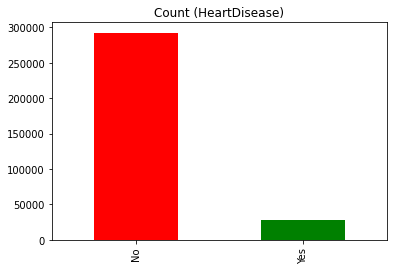

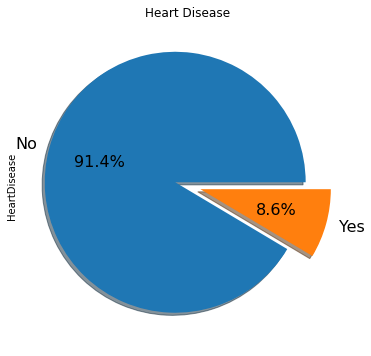

In [6]:
df['HeartDisease'].value_counts().plot(kind='bar', title='Count (HeartDisease)', color=['r', 'g'])
plt.figure(figsize=(6,6))

# Pie plot
df['HeartDisease'].value_counts().plot.pie(explode=[0.1,0.1], autopct='%1.1f%%', shadow=True, textprops={'fontsize':16}).set_title("Heart Disease")

In [7]:
features = df.columns
features

Index(['HeartDisease', 'BMI', 'Smoking', 'AlcoholDrinking', 'Stroke',
       'PhysicalHealth', 'MentalHealth', 'DiffWalking', 'Sex', 'AgeCategory',
       'Race', 'Diabetic', 'PhysicalActivity', 'GenHealth', 'SleepTime',
       'Asthma', 'KidneyDisease', 'SkinCancer'],
      dtype='object')

The data of people who have heart disease has only 8.56% in the dataset. So this shows the unbalanced data 

In [8]:
max_thresold= df.BMI.quantile( 0.95)
max_thresold

40.18

<AxesSubplot:xlabel='BMI'>

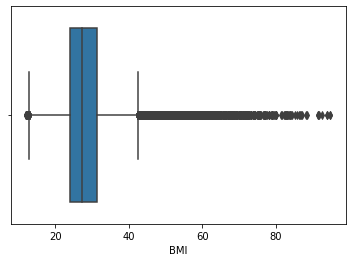

In [10]:
sns.boxplot(df['BMI'])

In [11]:
df[df.BMI>max_thresold].shape

(15900, 18)

In [12]:
min_threshold,max_thresoldS = df.SleepTime.quantile([0.01, 0.99])
min_threshold,max_thresoldS

(3.0, 12.0)

<AxesSubplot:xlabel='SleepTime'>

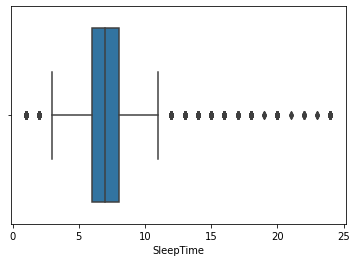

In [13]:
sns.boxplot(df['SleepTime'])

In [14]:
df[df.SleepTime>max_thresoldS].shape

(999, 18)

In [15]:
df[df.SleepTime<min_threshold].shape

(1339, 18)

In [16]:
df=df[(df.SleepTime < max_thresoldS)&(df.SleepTime > min_threshold)&(df.BMI <max_thresold)]

df.shape

(297732, 18)

<AxesSubplot:xlabel='PhysicalHealth'>

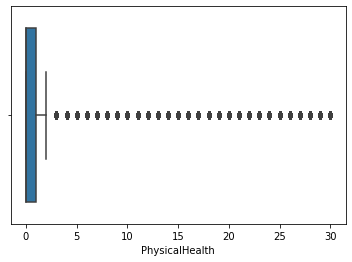

In [17]:
sns.boxplot(df['PhysicalHealth'])

In [18]:
max_thresold= df.PhysicalHealth.quantile( 0.85)
max_thresold

5.0

In [19]:
df[df.PhysicalHealth>max_thresold].shape

(40282, 18)

In [20]:
df=df[(df.PhysicalHealth <max_thresold)]

df.shape

(250568, 18)

<AxesSubplot:xlabel='MentalHealth'>

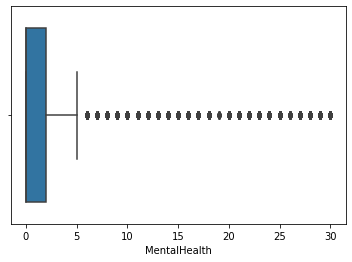

In [21]:
sns.boxplot(df['MentalHealth'])

In [22]:
max_thresold= df.MentalHealth.quantile( 0.85)
max_thresold

5.0

In [23]:
df[df.MentalHealth>max_thresold].shape

(34096, 18)

In [24]:
df=df[(df.MentalHealth <max_thresold)]

df.shape

(206010, 18)

Remove duplicated

In [25]:
df.duplicated().sum()

17775

In [26]:
df.drop_duplicates(inplace=True)
df.duplicated().sum()

0

In [27]:
df.isna().sum()

HeartDisease        0
BMI                 0
Smoking             0
AlcoholDrinking     0
Stroke              0
PhysicalHealth      0
MentalHealth        0
DiffWalking         0
Sex                 0
AgeCategory         0
Race                0
Diabetic            0
PhysicalActivity    0
GenHealth           0
SleepTime           0
Asthma              0
KidneyDisease       0
SkinCancer          0
dtype: int64

In [28]:
df['HeartDisease'].replace({'No':0,'Yes':1}, inplace=True)

df['Smoking'].replace({'No':0,'Yes':1}, inplace=True)

df['AlcoholDrinking'].replace({'No':0,'Yes':1}, inplace=True)

df['Stroke'].replace({'No':0,'Yes':1}, inplace=True)

df['DiffWalking'].replace({'No':0,'Yes':1}, inplace=True)

df['Diabetic'].replace({'No':0,'No, borderline diabetes':0,'Yes (during pregnancy)':1,'Yes':1}, inplace=True)

df['PhysicalActivity'].replace({'No':0,'Yes':1}, inplace=True)
df['Asthma'].replace({'No':0,'Yes':1}, inplace=True)

df['KidneyDisease'].replace({'No':0,'Yes':1}, inplace=True)

df['SkinCancer'].replace({'No':0,'Yes':1}, inplace=True)

df['Sex'].replace({'Male':0,'Female':1}, inplace=True)

df['AgeCategory'].replace({'18-24':0,'25-29':1,'30-34':2,'35-39':3,'40-44':4,'45-49':5,'50-54':6,'55-59':7,'60-64':8,'65-69':9,'70-74':10,'75-79':11,'80 or older':12}, inplace=True)

df['Race'].replace({'White':0,'Hispanic':1,'Black':2,'Asian':3,'American Indian/Alaskan Native':4,'Other':5}, inplace=True)

df['GenHealth'].replace({'Excellent':0,'Very good':1,'Good':2,'Fair':3,'Poor':4}, inplace=True)

In [32]:
df.describe()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
count,188235.000000,188235.000000,188235.000000,188235.000000,188235.000000,188235.000000,188235.000000,188235.000000,188235.000000,188235.000000,188235.000000,188235.000000,188235.000000,188235.000000,188235.000000,188235.000000,188235.000000,188235.000000
mean,0.075135,27.381782,0.393816,0.068021,0.029777,0.284341,0.401854,0.078524,0.488931,6.794448,0.558164,0.120982,0.807953,1.171323,7.176567,0.108232,0.028236,0.103238
std,0.263609,4.846994,0.488596,0.251783,0.169971,0.804821,0.955471,0.268995,0.499879,3.545073,1.197214,0.326107,0.393911,0.886884,1.121817,0.310674,0.165647,0.304270
min,0.000000,12.080000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000,0.000000
25%,0.000000,23.780000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000,1.000000,0.000000,6.000000,0.000000,0.000000,0.000000
50%,0.000000,26.940000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000,0.000000,0.000000,1.000000,1.000000,7.000000,0.000000,0.000000,0.000000
75%,0.000000,30.540000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,10.000000,0.000000,0.000000,1.000000,2.000000,8.000000,0.000000,0.000000,0.000000
max,1.000000,40.170000,1.000000,1.000000,1.000000,4.000000,4.000000,1.000000,1.000000,12.000000,5.000000,1.000000,1.000000,4.000000,11.000000,1.000000,1.000000,1.000000


# Random over sampling-Oversampling methods duplicate or create new synthetic examples in the minority class

In [33]:
count_class_0, count_class_1 = df.HeartDisease.value_counts()

# Divide by class
class_0 = df[df['HeartDisease'] == 0]
class_1 = df[df['HeartDisease'] == 1]
print(class_0.shape)
print(class_1.shape)

(174092, 18)
(14143, 18)


In [34]:
 df.HeartDisease.value_counts()

0    174092
1     14143
Name: HeartDisease, dtype: int64

In [35]:
class_1=class_1.sample(count_class_0,replace=True)
data = pd.concat([class_0, class_1], axis=0)
print(data.HeartDisease.value_counts())

0    174092
1    174092
Name: HeartDisease, dtype: int64


In [36]:
count_class_no, count_class_yes = df['HeartDisease'].value_counts()

# divide the class
df_class_yes = df[df['HeartDisease'] == 1]
df_class_no = df[df['HeartDisease'] == 0]

Random over-sampling
0    174092
1    174092
Name: HeartDisease, dtype: int64


Text(0.5, 1.0, 'Heart Disease')

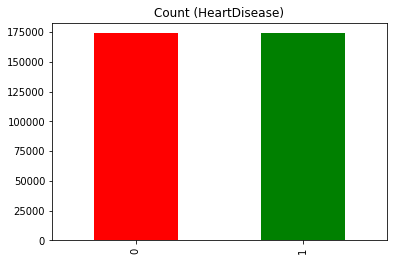

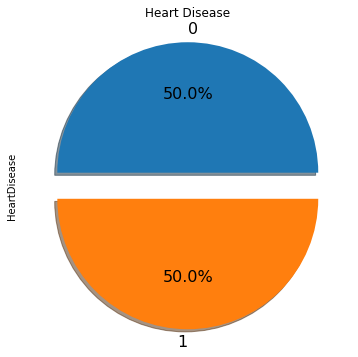

In [37]:
df_class_yes_over = df_class_yes.sample(count_class_no, replace=True)
df_test_over = pd.concat([df_class_no, df_class_yes_over], axis=0)

print('Random over-sampling')
print(df_test_over['HeartDisease'].value_counts())

df_test_over['HeartDisease'].value_counts().plot(kind='bar', title='Count (HeartDisease)', color=['r', 'g'])
plt.figure(figsize=(6,6))

# Pie plot
df_test_over['HeartDisease'].value_counts().plot.pie(explode=[0.1,0.1], autopct='%1.1f%%', shadow=True, textprops={'fontsize':16}).set_title("Heart Disease")

In [38]:
train, test = train_test_split(df_test_over,stratify=df_test_over['HeartDisease'],test_size=.2,random_state=0)
print("train.shape : {}".format(train.shape))
print("test.shape : {}".format(test.shape))

train.shape : (278547, 18)
test.shape : (69637, 18)


In [39]:
# Let us consider only the disease features
diseases = df_test_over[['HeartDisease', 'Stroke', 'Diabetic', 'KidneyDisease', 'SkinCancer']]
diseases.head()

,HeartDisease,Stroke,Diabetic,KidneyDisease,SkinCancer
1,0,1,0,0,0
3,0,0,0,0,1
8,0,0,0,1,0
11,0,0,0,0,0
12,0,0,1,0,0


In [40]:
 #understand if diabetes is influencing heart disease.
diabetics = df_test_over[df_test_over.Diabetic==1]
heart_d = sum(diabetics.HeartDisease)/len(diabetics)
print("The number of people with diabetes also having heart disease are")
print(heart_d)

heart_patients = df_test_over[df_test_over.HeartDisease==1]
diabs = sum(heart_patients.Diabetic)/len(heart_patients)
print("The number of people with heart disease also having diabetes are")
print(diabs)

The number of people with diabetes also having heart disease are
0.7200790267235104
The number of people with heart disease also having diabetes are
0.27844473037244677


In [41]:
cat_features = df_test_over.select_dtypes(include=['object']).columns.tolist()

In [42]:
def outlier(df_test_over, columns=None):
    if columns == None:
        columns = df_test_over.columns
    for col in columns:
        mean = df_test_over[col].mean()
        std = df_test_over[col].std()
        
        border = np.abs(df[col] - mean) / std
        
        df_test_over = df_test_over[(border < 3.0)]
    
    return df_test_over

In [43]:
def outlier_2(df_test_over, columns=None):
    if columns == None:
        columns = df.columns
    for col in columns:
        mean = df_test_over[col].mean()
        std = df_test_over[col].std()
        
        border = np.abs(df[col] - mean) / std
        
        df_test_over = df_test_over[(border < 1.9)]
    
    return df_test_over


In [44]:
def outlier_3(df_test_over, columns=None):
    if columns == None:
        columns = df.columns
    for col in columns:
        mean = df_test_over[col].mean()
        std = df_test_over[col].std()
        
        border = np.abs(df_test_over[col] - mean) / std
        
        df_test_over = df_test_over[(border < 1.2)]
    
    return df_test_over

In [45]:
print(train.shape)
train = outlier(train, ['SleepTime'])
print(train.shape)
train = outlier_2(train, ['BMI'])
print(train.shape)
train = outlier_3(train, ['PhysicalHealth'])
print(train.shape)
train = outlier_3(train, ['MentalHealth'])
print(train.shape)

(278547, 18)
(278173, 18)
(261655, 18)
(233678, 18)
(210518, 18)


In [46]:
print(test.shape)
test = outlier(test, ['SleepTime'])
print(test.shape)
test = outlier_2(test, ['BMI'])
print(test.shape)
test = outlier_3(test, ['PhysicalHealth'])
print(test.shape)
test = outlier_3(test, ['MentalHealth'])
print(test.shape)

(69637, 18)
(69532, 18)
(65413, 18)
(58534, 18)
(52797, 18)


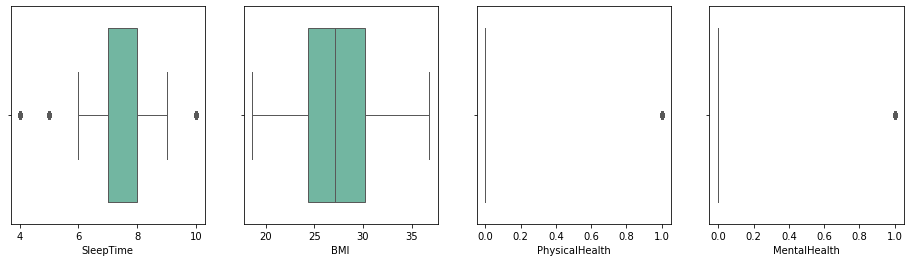

In [47]:
plt.subplots(1,4,figsize=(16,4))

plt.subplot(141)
sns.boxplot(train['SleepTime'],linewidth=1,palette='Set2')
plt.subplot(142)
sns.boxplot(train['BMI'],linewidth=1,palette='Set2')
plt.subplot(143)
sns.boxplot(train['PhysicalHealth'],linewidth=1,palette='Set2')
plt.subplot(144)
sns.boxplot(train['MentalHealth'],linewidth=1,palette='Set2')
plt.show()


In [48]:
train['Physical_MentalHealth'] = train['PhysicalHealth'] + train['MentalHealth']
test['Physical_MentalHealth'] = test['PhysicalHealth'] + test['MentalHealth']

In [49]:
train.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer,Physical_MentalHealth
222801,1,30.07,1,0,0,0.0,0.0,0,1,10,2,1,1,3,8.0,0,0,0,0.0
19905,0,32.64,0,0,0,0.0,0.0,0,0,9,0,0,0,2,8.0,0,0,1,0.0
68475,1,22.81,0,0,0,0.0,0.0,0,0,11,0,0,1,1,8.0,0,0,0,0.0
169247,1,22.15,1,0,1,0.0,0.0,0,0,11,0,0,1,2,7.0,0,0,0,0.0
74168,1,28.06,1,0,0,0.0,0.0,0,0,4,0,0,1,1,8.0,0,0,0,0.0


In [50]:
y_train = train['HeartDisease']
X_train = train.drop('HeartDisease',axis=1)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, stratify=train['HeartDisease'], test_size=.2, random_state=15)

y_test = test['HeartDisease']
X_test = test.drop('HeartDisease', axis=1)

In [51]:
X_train.head(5)

,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer,Physical_MentalHealth
117134,28.29,0,0,0,0.0,0.0,0,1,12,0,1,0,2,8.0,0,0,0,0.0
243744,23.89,1,1,0,0.0,0.0,0,1,5,0,0,1,0,8.0,1,0,0,0.0
52719,31.09,1,0,0,0.0,0.0,0,1,8,0,0,0,0,8.0,0,0,1,0.0
234412,28.08,1,0,0,0.0,0.0,0,0,12,0,0,1,1,8.0,0,0,0,0.0
76610,29.05,1,0,0,0.0,0.0,0,0,7,5,1,1,2,7.0,0,0,0,0.0


In [52]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [53]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
data = df_test_over.copy()
X = data.iloc[:,1:17]  #independent columns
y = data.iloc[:,-1]    #target column 
#apply SelectKBest class to extract top best features
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(18,'Score'))  #print best features

               Specs         Score
8        AgeCategory  32328.853617
9               Race  16253.024475
15     KidneyDisease   1290.021465
5       MentalHealth   1144.644317
6        DiffWalking    904.230428
7                Sex    636.735378
12         GenHealth    628.869159
3             Stroke    529.411049
10          Diabetic    289.456420
4     PhysicalHealth    226.488115
13         SleepTime    169.163321
0                BMI    161.309086
1            Smoking    149.168088
11  PhysicalActivity     43.645941
2    AlcoholDrinking     33.385722
14            Asthma      1.495020


In [54]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

def print_score(clf, X_train, y_train, X_test, y_test, train=True):
    if train:
        pred = clf.predict(X_train)
        clf_report = pd.DataFrame(classification_report(y_train, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(y_train, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, pred)}\n")
        
    elif train==False:
        pred = clf.predict(X_test)
        clf_report = pd.DataFrame(classification_report(y_test, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")

In [55]:
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection
from sklearn.model_selection import cross_val_score
import xgboost as xgb
# function initializing baseline machine learning models
def GetBasedModel():
    basedModels = []
    basedModels.append(('LR_L2'   , LogisticRegression(penalty='l2')))
    basedModels.append(('LDA'  , LinearDiscriminantAnalysis()))
    basedModels.append(('KNN7'  , KNeighborsClassifier(7)))
    basedModels.append(('KNN5'  , KNeighborsClassifier(5)))
    basedModels.append(('KNN9'  , KNeighborsClassifier(9)))
    basedModels.append(('KNN11'  , KNeighborsClassifier(11)))
    basedModels.append(('CART' , DecisionTreeClassifier()))
    basedModels.append(('NB'   , GaussianNB()))
    #basedModels.append(('SVM Linear'  , SVC(kernel='linear',gamma='auto',probability=True)))
    #basedModels.append(('SVM RBF'  , SVC(kernel='rbf',gamma='auto',probability=True)))
    basedModels.append(('AB'   , AdaBoostClassifier()))
    basedModels.append(('GBM'  , GradientBoostingClassifier(n_estimators=100,max_features='sqrt')))
    basedModels.append(('RF_Ent100'   , RandomForestClassifier(criterion='entropy',n_estimators=100)))
    basedModels.append(('RF_Gini100'   , RandomForestClassifier(criterion='gini',n_estimators=100)))
    basedModels.append(('ET100'   , ExtraTreesClassifier(n_estimators= 100)))
    basedModels.append(('ET500'   , ExtraTreesClassifier(n_estimators= 500)))
    basedModels.append(('MLP', MLPClassifier()))
    basedModels.append(('SGD3000', SGDClassifier(max_iter=1000, tol=1e-4)))
    basedModels.append(('XGB_2000', xgb.XGBClassifier(n_estimators= 2000)))
    basedModels.append(('XGB_500', xgb.XGBClassifier(n_estimators= 500)))
    basedModels.append(('XGB_100', xgb.XGBClassifier(n_estimators= 100)))
    basedModels.append(('XGB_1000', xgb.XGBClassifier(n_estimators= 1000)))
    basedModels.append(('ET1000'   , ExtraTreesClassifier(n_estimators= 1000)))
    
    return basedModels

In [56]:
def BasedLine2(X_train, y_train,models):
    # Test options and evaluation metric
    num_folds = 10
    scoring = 'accuracy'
    seed = 7
    results = []
    names = []
    for name, model in models:
        kfold = model_selection.KFold(n_splits=10, random_state=seed, shuffle = True)
        cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
    return results,msg

In [57]:
models = GetBasedModel()
names,results = BasedLine2(X_train, y_train,models)

LR_L2: 0.747759 (0.003424)
LDA: 0.748210 (0.003111)
KNN7: 0.842751 (0.002780)
KNN5: 0.870818 (0.003066)
KNN9: 0.819605 (0.002498)
KNN11: 0.803045 (0.003602)
CART: 0.943538 (0.001882)
NB: 0.686914 (0.003444)
AB: 0.747331 (0.003374)
GBM: 0.752087 (0.003082)
RF_Ent100: 0.951495 (0.000736)
RF_Gini100: 0.952332 (0.000901)
ET100: 0.958804 (0.000652)
ET500: 0.958745 (0.000877)
MLP: 0.764265 (0.004567)
SGD3000: 0.747046 (0.003327)
XGB_2000: 0.910471 (0.002635)
XGB_500: 0.847228 (0.004446)
XGB_100: 0.786336 (0.003202)
XGB_1000: 0.881043 (0.004122)
ET1000: 0.958739 (0.000595)


In [58]:
rf_ent = RandomForestClassifier(criterion='entropy',n_estimators=100)
rf_ent.fit(X_train, y_train)
y_pred_rfe = rf_ent.predict(X_test)

In [59]:
mlp = MLPClassifier()
mlp.fit(X_train,y_train)
y_pred_mlp = mlp.predict(X_test)

In [60]:
knn = KNeighborsClassifier(9)
knn.fit(X_train,y_train)
y_pred_knn = knn.predict(X_test)

In [61]:
et_500 = ExtraTreesClassifier(n_estimators= 500)
et_500.fit(X_train,y_train)
y_pred_et500 = et_500.predict(X_test)

In [62]:
xgb = xgb.XGBClassifier(n_estimators= 100)
xgb.fit(X_train,y_train)
y_pred_xgb = xgb.predict(X_test)

In [63]:
sgd = SGDClassifier(max_iter=1000, tol=1e-4)
sgd.fit(X_train,y_train)
y_pred_sgd = sgd.predict(X_test)

In [64]:
ada = AdaBoostClassifier()
ada.fit(X_train,y_train)
y_pred_ada = ada.predict(X_test)

In [65]:
decc = DecisionTreeClassifier()
decc.fit(X_train,y_train)
y_pred_decc = decc.predict(X_test)

In [66]:
gbm = GradientBoostingClassifier(n_estimators=100,max_features='sqrt')
gbm.fit(X_train,y_train)
y_pred_gbm = gbm.predict(X_test)

In [67]:
import xgboost as xgboost
# selecting list of top performing models to be used in stacked ensemble method
models = [
    RandomForestClassifier(criterion='entropy',n_estimators=100),
    MLPClassifier(),
    RandomForestClassifier(criterion='gini',n_estimators=100),
    KNeighborsClassifier(9),
    ExtraTreesClassifier(n_estimators= 500),
    ExtraTreesClassifier(n_estimators= 100),
    xgboost.XGBClassifier(n_estimators= 1000),
    xgboost.XGBClassifier(n_estimators= 100),
    xgboost.XGBClassifier(n_estimators= 500),
    xgboost.XGBClassifier(n_estimators= 2000),
    xgboost.XGBClassifier(),
    SGDClassifier(max_iter=1000, tol=1e-4),
    AdaBoostClassifier(),
    DecisionTreeClassifier(),
    LinearDiscriminantAnalysis(),
    GradientBoostingClassifier(n_estimators=100,max_features='sqrt'),
    ExtraTreesClassifier(n_estimators= 1000),
]

In [68]:
S_train, S_test = stacking(models,                   
                           X_train, y_train, X_test,   
                           regression=False, 
     
                           mode='oof_pred_bag', 
       
                           needs_proba=False,
         
                           save_dir=None, 
            
                           metric=accuracy_score, 
    
                           n_folds=5, 
                 
                           stratified=True,
            
                           shuffle=True,  
                           random_state=0,    
         
                           verbose=2)

task:         [classification]
n_classes:    [2]
metric:       [accuracy_score]
mode:         [oof_pred_bag]
n_models:     [17]

model  0:     [RandomForestClassifier]
    fold  0:  [0.94629338]
    fold  1:  [0.94501677]
    fold  2:  [0.94902473]
    fold  3:  [0.94593712]
    fold  4:  [0.94646992]
    ----
    MEAN:     [0.94654839] + [0.00133589]
    FULL:     [0.94654839]

model  1:     [MLPClassifier]
    fold  0:  [0.76658849]
    fold  1:  [0.76525250]
    fold  2:  [0.76810260]
    fold  3:  [0.76379776]
    fold  4:  [0.76200938]
    ----
    MEAN:     [0.76515015] + [0.00212083]
    FULL:     [0.76515017]

model  2:     [RandomForestClassifier]
    fold  0:  [0.94679809]
    fold  1:  [0.94656058]
    fold  2:  [0.94949975]
    fold  3:  [0.94765906]
    fold  4:  [0.94736061]
    ----
    MEAN:     [0.94757562] + [0.00103830]
    FULL:     [0.94757562]

model  3:     [KNeighborsClassifier]
    fold  0:  [0.80711338]
    fold  1:  [0.80553989]
    fold  2:  [0.81031975]
   

In [69]:
model = MLPClassifier()
    
model = model.fit(S_train, y_train)
y_pred = model.predict(S_test)
print('Final prediction score: [%.8f]' % accuracy_score(y_test, y_pred))

Final prediction score: [0.98018827]
